# Bernstein-Vazirani Algorithm

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
qml.drawer.use_style(style='sketch')

**Problem**

Given a function $f$ that takes as input a string of bits $x$ and returns either $0$ or $1$, determine the unique string $s$ such that $f(x) = s \cdot x \, \text{(mod 2)}$ for all $x$.

## Classical Solution

Since $s_i = f(e_i)$, where $e_i$ is the $i$th standard basis vector, we can determine $s$ by querying $f$ for each $e_i$.

In [3]:
class ClassicOracle:
    def __init__(self, s):
        self.s = s
    
    def __call__(self, x):
        return np.dot(self.s, x) % 2

In [4]:
s = np.random.randint(2, size=100)

In [5]:
oracle = ClassicOracle(s)

In [6]:
def find_s_classic(oracle):
    s = np.zeros(100)
    for i in range(100):
        x = np.zeros(100)
        x[i] = 1
        s[i] = oracle(x)
    return s

In [7]:
np.array_equal(s, find_s_classic(oracle))

True

## Quantum Solution

In [8]:
from pennylane.operation import Operation

class Oracle(Operation):
    num_params = 1
    num_wires = qml.operation.AnyWires

    @staticmethod
    def compute_decomposition(s, wires):
        gates = []
        n = len(wires) - 1
        for i in range(n):
            if s[i] == 1:
                gates.append(qml.CNOT(wires=[wires[i], wires[n]]))
                
        return gates

**Explanation of `Oracle`**

We want to implement the function $f(x)$ such that

$$
|x\rangle \otimes |0\rangle \xrightarrow{U_f} |x\rangle \otimes |s\cdot x \, (\text{mod 2})\rangle = |x\rangle \otimes |\bigoplus_{i=0}^{n-1} s_i x_i\rangle = |x\rangle \otimes |\bigoplus_{i \in \mathcal{I}} x_i \rangle
$$
where $\mathcal{I} = \{i \mid s_i = 1\}$.

In [9]:
dev = qml.device('default.qubit', wires=4)
s = np.random.randint(2, size=3)
print(s)

@qml.qnode(dev)
def oracle_test(state):
    qml.BasisStatePreparation(state, wires=range(3))
    Oracle(s, wires=range(4))
    return qml.probs(wires=3)

[1 0 0]


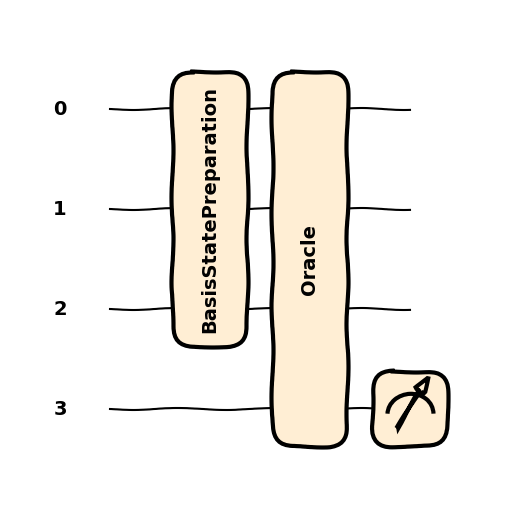

In [10]:
qml.draw_mpl(oracle_test)(np.array([1, 0, 0]))
plt.show()

In [11]:
for state in [[1,0,0],[0,1,0],[0,0,1]]:
    # output computational basis to z basis
    result = oracle_test(state)
    print(np.where(result == 1)[0][0])

1
0
0


In [12]:
def gen_bernstein_vazirani(s):
    n = len(s)
    dev = qml.device('default.qubit', wires=n+1)

    @qml.qnode(dev)
    def circuit():
        # Last state to |->
        qml.PauliX(wires=n)
        qml.Hadamard(wires=n)

        qml.Barrier(wires=range(n+1))
        
        # Apply Hadamard to n qubits
        for i in range(n):
            qml.Hadamard(wires=i)
        

        # Apply oracle
        qml.Barrier(wires=range(n+1))
        Oracle(s, wires=range(n+1))
        qml.Barrier(wires=range(n+1))

        # Apply Hadamard to n qubits
        for i in range(n):
            qml.Hadamard(wires=i)
        
        # Measure
        return qml.probs(wires=range(n))

    return dev, circuit

In [13]:
dev, circuit = gen_bernstein_vazirani(s)

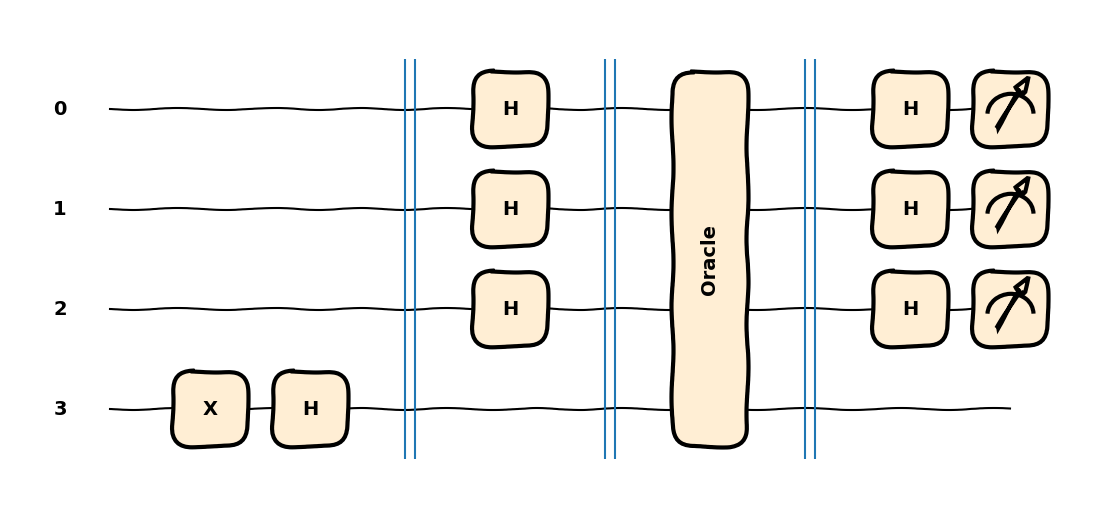

In [14]:
qml.draw_mpl(circuit)()
plt.show()

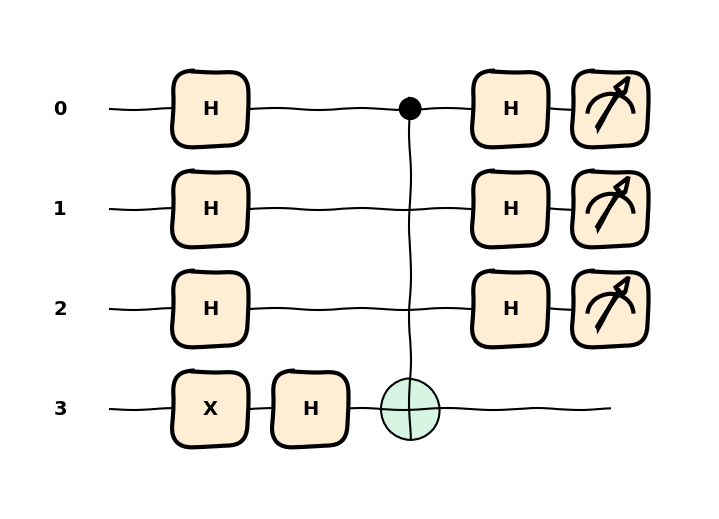

In [15]:
qml.draw_mpl(circuit, expansion_strategy='device')()
plt.show()

**Explanation of Bernstein-Vazirani Algorithm**

1) Make the last qubit $|-\rangle$.

2) Apply Hadamard gates to first $n$ qubits.
   $$
    |0\rangle^{\otimes n} \otimes |-\rangle \xrightarrow{H^{\otimes n} \otimes I} \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \otimes |-\rangle
   $$

3) Apply $U_f$.
   $$
   \begin{aligned}
    \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \otimes |-\rangle &\xrightarrow{U_f} \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \otimes \frac{1}{\sqrt{2}}(|s\cdot x\rangle - |1 \oplus s\cdot x\rangle) \\
    &= \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{s\cdot x} |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) \\
    &= \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{s\cdot x} |x\rangle \otimes |-\rangle
   \end{aligned}
   $$

4) Apply Hadamard gates to first $n$ qubits.
   $$
   \begin{aligned}
   \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{s\cdot x} |x\rangle &\xrightarrow{H^{\otimes n} \otimes I} \frac{1}{2^n} \sum_{x \in \{0, 1\}^n} \sum_{y \in \{0, 1\}^n} (-1)^{s\cdot x} (-1)^{x \cdot y} |y\rangle \\
   &= \frac{1}{2^n} \sum_{y \in \{0, 1\}^n} \sum_{x \in \{0, 1\}^n} (-1)^{x \cdot (s \oplus y)} |y\rangle \\
   &= |s\rangle
   \end{aligned}
   $$
   For the last equality, note that $\displaystyle \sum_{x \in \{0, 1\}^n} (-1)^{x \cdot (s \oplus y)} = 2^n$ if $s = y~ (s \oplus y = \vec{0})$ and $0$ otherwise.

In [16]:
s = np.random.randint(2, size=10)
dev, circuit = gen_bernstein_vazirani(s)
result = circuit()
print(result)

[0. 0. 0. ... 0. 0. 0.]


In [17]:
k = np.where(result == np.max(result))[0][0]
s_hat_bin = np.binary_repr(k, width=10)
s_hat = np.array(list(map(int, list(s_hat_bin))))
s_hat

tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1], requires_grad=True)

In [18]:
np.array_equal(s, s_hat)

True